In [22]:
import numpy as np
import networkx as nx
import random
from copy import deepcopy
import matplotlib.pyplot as plt

## The Problem (30%)

### Description of the problem

The problem I've chosen is traffic light optimization across a city road network. In urban environments, inefficient traffic light timings cause congestion, increased travel times, and higher emissions. This optimization problem aims to synchronize traffic lights to minimize vehicle stops and waiting times, creating "green waves" where vehicles can travel through multiple intersections without stopping.

Specifically, the problem involves determining the optimal timing parameters for each traffic light:
- Green phase duration
- Yellow phase duration 
- Red clearance interval (safety buffer)
- Coordination with adjacent intersections

The objective is to minimize the average travel time and number of stops experienced by vehicles traversing the network, while maximizing the occurrence of "green waves" where vehicles can proceed through consecutive intersections without stopping.

### Discussion of the suitability of Genetic Algorithms

Genetic Algorithms (GAs) are well-suited for traffic light optimization for several reasons:

1. **Complex search space**: The problem has numerous parameters across multiple intersections, creating a vast solution space that traditional optimization methods would struggle with.

2. **Non-linear interactions**: Traffic flow dynamics create complex, non-linear relationships between parameters that GAs can navigate through evolutionary processes.

3. **Multiple competing objectives**: The problem requires balancing travel time, number of stops, and green wave efficiency - GAs can optimize multiple objectives simultaneously.

4. **No derivative information**: The objective function for traffic systems lacks clear derivatives needed for gradient-based methods, making evolutionary approaches appropriate.

5. **Adaptability**: GAs can discover diverse solutions adapted to different traffic patterns and network topologies.

6. **Parallelization potential**: Traffic simulation evaluations can be parallelized, taking advantage of GA's population-based approach.

### Complexity of the problem

The traffic light optimization problem is highly complex for several reasons:

1. **Combinatorial explosion**: With n intersections and k timing parameters per intersection, the solution space grows as O(k^n).

2. **Temporal dependencies**: Adjusting one traffic light affects downstream traffic patterns with time-delayed effects.

3. **Stochastic elements**: Traffic flow has inherent variability, requiring robust solutions.

4. **Network structure impact**: The underlying road network topology affects optimal timing patterns.

5. **Multi-modal optimization**: Solutions must balance conflicting objectives (travel time vs. stops vs. green wave efficiency).

The problem's complexity increases with network size, making it challenging but appropriate for a genetic algorithm approach.

## The problem and the cost function (20%)

In [23]:
class problem:
    def __init__(self):
        # Required attributes from Genetic_24.ipynb
        self.number_of_genes = 10  # Number of intersections
        self.max_value = 60       # Placeholder max (e.g., for green time)
        self.min_value = 5        # Placeholder min (e.g., for green time)
        self.cost_function = self.network_fitness_function
        
        # Traffic-specific attributes
        self.connection_radius = 0.3
        self.road_network = nx.random_geometric_graph(self.number_of_genes, self.connection_radius)
        self.ensure_fully_connected()
        self.opposite_lights = self.find_opposite_lights()
        self.road_distances = {}
        self.road_speeds = {}
        for (start, end) in self.road_network.edges():
            distance = random.randint(200, 1000)  # Meters
            speed = random.choice([11.11, 13.89, 16.67])  # 40, 50, 60 km/h in m/s
            self.road_distances[(start, end)] = distance
            self.road_distances[(end, start)] = distance
            self.road_speeds[(start, end)] = speed
            self.road_speeds[(end, start)] = speed

    def ensure_fully_connected(self):
        """Ensures the road network is fully connected."""
        components = list(nx.connected_components(self.road_network))
        if len(components) > 1:
            for i in range(len(components) - 1):
                node_a = random.choice(list(components[i]))
                node_b = random.choice(list(components[i + 1]))
                self.road_network.add_edge(node_a, node_b)

    def find_opposite_lights(self):
        """Identifies opposite traffic lights for coordination."""
        opposite_lights = {}
        for node in self.road_network.nodes():
            neighbors = list(self.road_network.neighbors(node))
            if len(neighbors) < 2:
                continue
            sorted_neighbors = sorted(neighbors, key=lambda x: nx.shortest_path_length(self.road_network, node, x))
            for i in range(len(sorted_neighbors) - 1):
                opposite_lights[sorted_neighbors[i]] = sorted_neighbors[i + 1]
                opposite_lights[sorted_neighbors[i + 1]] = sorted_neighbors[i]
        return opposite_lights

    def visualize_network(self):
        """Visualizes the road network."""
        plt.figure(figsize=(10, 8))
        pos = nx.get_node_attributes(self.road_network, 'pos')
        nx.draw(self.road_network, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
        plt.title("Road Network Visualization")
        plt.show()

    def adjust_red_timings(self, chromosome, opposite_lights):
        """Adjusts red timings based on opposite lights with a minimum red time."""
        red_times = np.zeros(self.number_of_genes)
        cycle_lengths = np.zeros(self.number_of_genes)
        MIN_RED_TIME = 10  # Minimum red time in seconds for safety
        
        # Calculate cycle length for each junction
        for i in range(self.number_of_genes):
            green = chromosome[3*i]
            yellow = chromosome[3*i + 1]
            red_stop = chromosome[3*i + 2]
            cycle_lengths[i] = green + yellow + red_stop
        
        # Adjust red times
        for node in range(self.number_of_genes):
            if node in opposite_lights:
                opposite_node = opposite_lights[node]
                # Red time should cover the green + yellow of the opposite light
                opposite_green = chromosome[3*opposite_node]
                opposite_yellow = chromosome[3*opposite_node + 1]
                red_times[node] = opposite_green + opposite_yellow
            else:
                # Default red time for junctions without opposite lights
                red_times[node] = cycle_lengths[node] * 0.5  # Half the cycle length as a heuristic
            
            # Enforce minimum red time
            red_times[node] = max(MIN_RED_TIME, red_times[node])
        
        return red_times

    def network_fitness_function(self, chromosome):
        """Evaluates traffic light configuration fitness, returning fitness and green wave efficiency."""
        total_stops = 0
        total_travel_time = 0
        successful_green_passes = 0
        total_segments = 0
        num_vehicles = 500

        for _ in range(num_vehicles):
            start = random.randint(0, self.number_of_genes - 1)
            end = random.randint(0, self.number_of_genes - 1)
            if start == end:
                continue
            try:
                path = nx.shortest_path(self.road_network, source=start, target=end)
            except nx.NetworkXNoPath:
                continue

            for i in range(len(path) - 1):
                current_node = path[i]
                next_node = path[i + 1]
                time_to_next = self.road_distances.get((current_node, next_node), 500) / self.road_speeds.get((current_node, next_node), 13.89)
                green_time = chromosome[3 * next_node]  # Green time
                red_stop_time = chromosome[3 * next_node + 2]  # Red stop time

                if time_to_next > green_time:
                    total_stops += 1
                    total_travel_time += red_stop_time  # Wait at red light
                else:
                    successful_green_passes += 1
                total_travel_time += time_to_next
                total_segments += 1

        avg_stops = total_stops / max(num_vehicles, 1)
        avg_travel_time = total_travel_time / max(num_vehicles, 1)
        green_wave_efficiency = (successful_green_passes / max(total_segments, 1)) * 100
        
        # Fitness: Higher is better
        fitness = 100 - (avg_travel_time / 60 + avg_stops * 5)
        return fitness, green_wave_efficiency

## The Individual (30%)

### Chromosome
The chromosome is like a list that holds all the traffic light settings for the whole network. We have 10 intersections, and each one needs three settings: green time (how long the light is green), yellow time (how long it’s yellow), and red_stop time (a short safety pause after red). So, the chromosome is a numpy array with 30 numbers: [green0, yellow0, red_stop0, green1, yellow1, red_stop1, ..., green9, yellow9, red_stop9]. Green times can be between 20 and 60 seconds, yellow times between 3 and 8 seconds, and red_stop times between 3 and 5 seconds. The actual red time (how long cars wait at a red light) isn’t in the chromosome—it’s figured out later to make sure lights work well together.

### Crossover
Crossover is how we mix two parent chromosomes to make two new child chromosomes. We use a method called alpha-blending from Genetic_24.ipynb. Here’s how it works: we pick a random number called alpha between -0.2 and 1.2 (since explore_crossover is 0.2). Then, for the first child, we mix the parents like this: child1 = alpha * parent1 + (1-alpha) * parent2. The second child is the opposite: child2 = alpha * parent2 + (1-alpha) * parent1. This mixes all the numbers in the chromosomes together. After mixing, we make sure the numbers stay in the right range (like green can’t be less than 20 or more than 60). This way, the children get a bit of both parents, which helps improve the timings step by step.

### Mutation
Mutation is how we add some randomness to explore new ideas. For each number in the chromosome, there’s a 30% chance we change it. If we do change it, we add or subtract a random number between -10 and 10. Then, we make sure the number stays in the right range: green between 20 and 60, yellow between 3 and 8, and red_stop between 3 and 5. This keeps the timings realistic (like making sure yellow is long enough for safety) while letting us try new settings to find better ones.

### Discussion and Justification on the Approaches Taken

**Chromosome Design**: The numpy array representation was chosen because:
- It aligns with the `Genetic_24.ipynb` format, ensuring compatibility with the provided genetic operations (crossover, mutation).
- It supports the fixed network size of 10 intersections, with a clear structure for encoding the three parameters per intersection.

**Crossover Strategy**: The alpha-blending crossover was selected because:
- It mixes the parents’ timings a little at a time, which is good for traffic lights since small changes can make things better without breaking what’s already working.
- It keeps good timing patterns (like ones that make green waves) while trying new ideas, thanks to the explore_crossover part that lets us go a bit beyond the parents.
- It’s better than something like single-point crossover, which might split the chromosome in a way that messes up timings that need to work together across intersections.

**Mutation Implementation**: The random adjustment approach for mutation was chosen because:
- It allows fine-tuning of individual timing parameters, enabling the algorithm to explore small variations that might improve traffic flow.
- It keeps the timings realistic by sticking to the right ranges (like not making yellow too short, which would be unsafe).
- The mutation rate (0.3) and magnitude (±10) are balanced to avoid excessive disruption while enabling sufficient exploration, helping the algorithm escape local optima and maintain genetic diversity.

In [24]:
class individual:
    def __init__(self, prob):
        self.problem = prob
        num_nodes = prob.number_of_genes
        self.chromosome = np.zeros(3 * num_nodes)  # [green, yellow, red_stop] per node
        for i in range(num_nodes):
            self.chromosome[3*i] = random.randint(20, 60)      # Green: 20-60s
            self.chromosome[3*i + 1] = random.randint(3, 8)   # Yellow: 3-8s
            self.chromosome[3*i + 2] = random.randint(3, 5)   # Red_stop: 3-5s
        self.cost, self.green_wave_efficiency = prob.cost_function(self.chromosome)

    def mutate(self, rate_of_gene_mutation, range_of_gene_mutation):
        for i in range(len(self.chromosome)):
            if np.random.uniform() < rate_of_gene_mutation:
                if i % 3 == 0:  # Green time
                    self.chromosome[i] = max(20, min(60, self.chromosome[i] + random.randint(-range_of_gene_mutation, range_of_gene_mutation)))
                elif i % 3 == 1:  # Yellow time
                    self.chromosome[i] = max(3, min(8, self.chromosome[i] + random.randint(-range_of_gene_mutation, range_of_gene_mutation)))
                else:  # Red_stop time
                    self.chromosome[i] = max(3, min(5, self.chromosome[i] + random.randint(-range_of_gene_mutation, range_of_gene_mutation)))
        self.cost, self.green_wave_efficiency = self.problem.cost_function(self.chromosome)

    def crossover(self, parent2, explore_crossover):
        alpha = np.random.uniform(-explore_crossover, 1 + explore_crossover)
        child1 = deepcopy(self)
        child2 = deepcopy(parent2)
        child1.chromosome = alpha * self.chromosome + (1 - alpha) * parent2.chromosome
        child2.chromosome = alpha * parent2.chromosome + (1 - alpha) * self.chromosome
        for i in range(len(child1.chromosome)):
            if i % 3 == 0:  # Green
                child1.chromosome[i] = max(20, min(60, child1.chromosome[i]))
                child2.chromosome[i] = max(20, min(60, child2.chromosome[i]))
            elif i % 3 == 1:  # Yellow
                child1.chromosome[i] = max(3, min(8, child1.chromosome[i]))
                child2.chromosome[i] = max(3, min(8, child2.chromosome[i]))
            else:  # Red_stop
                child1.chromosome[i] = max(3, min(5, child1.chromosome[i]))
                child2.chromosome[i] = max(3, min(5, child2.chromosome[i]))
        child1.cost, child1.green_wave_efficiency = self.problem.cost_function(child1.chromosome)
        child2.cost, child2.green_wave_efficiency = self.problem.cost_function(child2.chromosome)
        return child1, child2

## Running the algorithm (10%)

### Parameter choices

I've selected the following parameters for the genetic algorithm:

1. **Population size: 30** - Large enough to maintain diversity while being computationally efficient
2. **Number of generations: 50** - Sufficient to observe convergence while limiting computation time
3. **Mutation rate: 0.3** - Balances exploration vs. exploitation
4. **Selection method: Tournament selection** - Provides good selection pressure while maintaining diversity
5. **Elitism: Top individual preserved** - Ensures best solution isn't lost between generations

### Modifications to the genetic algorithm

I've modified the standard genetic algorithm in several ways:

1. **Problem-specific fitness function** that considers both travel time and stop frequency
2. **Traffic light coordination mechanism** via the adjust_red_timings function
3. **Blended crossover** rather than traditional single-point crossover
4. **Parameter constraints** to ensure realistic traffic light timings
5. **Green wave efficiency tracking** as a secondary evaluation metric

### Rationale for the modifications

These modifications were made to address specific challenges in traffic optimization:

1. The fitness function balances multiple objectives important in traffic management
2. The coordination mechanism ensures lights are synchronized for better flow
3. Blended crossover preserves beneficial timing relationships between intersections
4. Parameter constraints ensure solutions are realistic and implementable
5. Green wave tracking helps evaluate solution quality beyond raw fitness numbers


In [25]:
# Parameters class
class parameters:
    def __init__(self):
        self.population = 30
        self.number_of_generations = 50
        self.child_rate_per_generation = 1
        self.crossover_explore_rate = 0.2
        self.gene_mutate_range = 10
        self.gene_mutate_rate = 0.3

In [26]:
# Helper function for parent selection
def choose_indices_from(number_in_list):
    index_1 = np.random.randint(number_in_list)
    index_2 = np.random.randint(number_in_list)
    if index_1 == index_2:
        return choose_indices_from(number_in_list)
    return index_1, index_2

In [27]:
def run_genetic(prob, params):
    prob.visualize_network()  # Show road network visualization
    cost_function = prob.cost_function
    population = []
    best_solution = individual(prob)
    best_solution.cost = -np.inf  # Maximize fitness
    fitness_history = []
    green_wave_history = []

    # Initialize population
    for i in range(params.population):
        new_individual = individual(prob)
        population.append(new_individual)
        if new_individual.cost > best_solution.cost:  # Maximize
            best_solution = deepcopy(new_individual)
    fitness_history.append(best_solution.cost)
    green_wave_history.append(best_solution.green_wave_efficiency)
    print(f"Generation 0: Best Fitness = {best_solution.cost:.5f}, Green Wave Efficiency = {best_solution.green_wave_efficiency:.2f}%")

    # Evolution loop
    for generation in range(params.number_of_generations):
        children = []
        while len(children) < params.child_rate_per_generation * params.population:
            parent1_index, parent2_index = choose_indices_from(len(population))
            parent1 = population[parent1_index]
            parent2 = population[parent2_index]
            child1, child2 = parent1.crossover(parent2, params.crossover_explore_rate)
            child1.mutate(params.gene_mutate_rate, params.gene_mutate_range)
            child1.cost, child1.green_wave_efficiency = cost_function(child1.chromosome)
            child2.mutate(params.gene_mutate_rate, params.gene_mutate_range)
            child2.cost, child2.green_wave_efficiency = cost_function(child2.chromosome)
            children.append(child1)
            children.append(child2)
        
        population.extend(children)
        population = sorted(population, key=lambda ind: ind.cost, reverse=True)[:params.population]  # Maximize
        if population[0].cost > best_solution.cost:  # Maximize
            best_solution = deepcopy(population[0])
        fitness_history.append(best_solution.cost)
        green_wave_history.append(best_solution.green_wave_efficiency)
        print(f"Generation {generation + 1}: Best Fitness = {best_solution.cost:.5f}, Green Wave Efficiency = {best_solution.green_wave_efficiency:.2f}%")

    # Plot Fitness and Green Wave Efficiency side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(fitness_history, 'b-')
    ax1.set_title("Fitness Evolution")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness Score")
    ax2.plot(green_wave_history, 'g-')
    ax2.set_title("Green Wave Efficiency Evolution")
    ax2.set_xlabel("Generation")
    ax2.set_ylabel("Green Wave Efficiency (%)")
    plt.tight_layout()
    plt.show()

    # Combined comparison plot
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, 'b-', label='Fitness Score')
    plt.plot(green_wave_history, 'g-', label='Green Wave Efficiency (%)')
    plt.title("Comparison of Green Wave Efficiency and Fitness Score Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    return best_solution

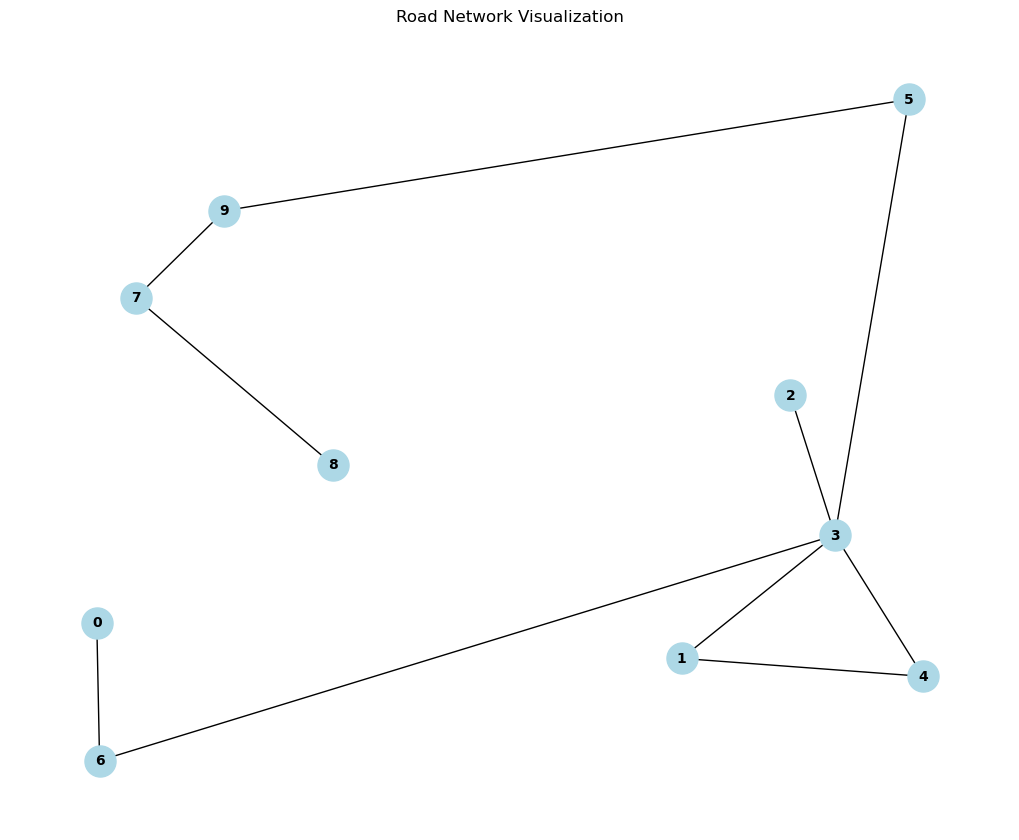

Generation 0: Best Fitness = 92.00849, Green Wave Efficiency = 53.40%
Generation 1: Best Fitness = 92.00849, Green Wave Efficiency = 53.40%
Generation 2: Best Fitness = 92.00849, Green Wave Efficiency = 53.40%
Generation 3: Best Fitness = 92.00849, Green Wave Efficiency = 53.40%
Generation 4: Best Fitness = 92.00849, Green Wave Efficiency = 53.40%
Generation 5: Best Fitness = 92.53970, Green Wave Efficiency = 52.79%
Generation 6: Best Fitness = 92.53970, Green Wave Efficiency = 52.79%
Generation 7: Best Fitness = 92.53970, Green Wave Efficiency = 52.79%
Generation 8: Best Fitness = 92.63699, Green Wave Efficiency = 55.21%
Generation 9: Best Fitness = 92.63699, Green Wave Efficiency = 55.21%
Generation 10: Best Fitness = 92.72993, Green Wave Efficiency = 53.72%
Generation 11: Best Fitness = 92.72993, Green Wave Efficiency = 53.72%
Generation 12: Best Fitness = 92.72993, Green Wave Efficiency = 53.72%
Generation 13: Best Fitness = 92.72993, Green Wave Efficiency = 53.72%
Generation 14: B

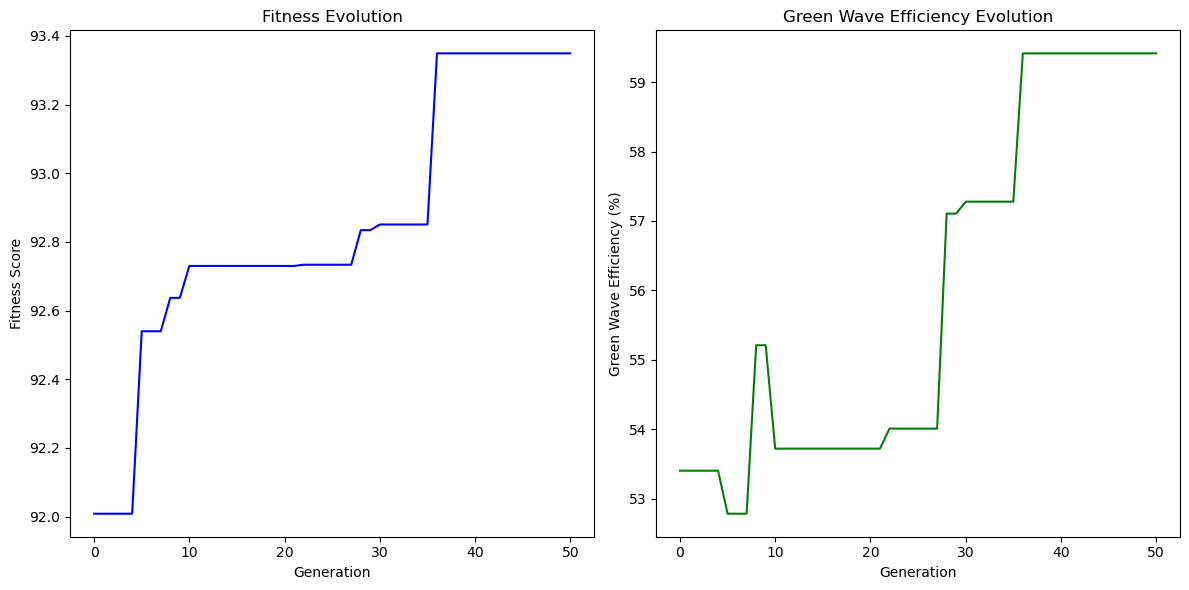

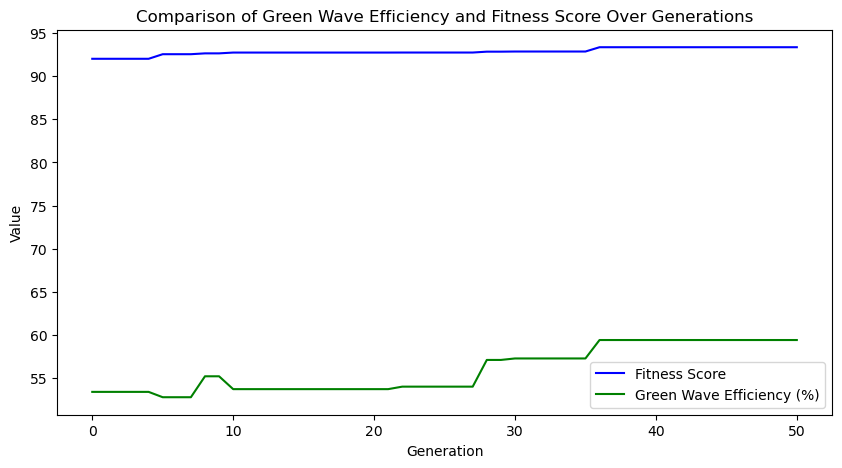


Best Solution:
Junction 0 → Green: 50s, Yellow: 3s, Red_Stop: 3s, Red Time: 68.00s
Junction 1 → Green: 60s, Yellow: 8s, Red_Stop: 3s, Red Time: 68.00s
Junction 2 → Green: 44s, Yellow: 8s, Red_Stop: 3s, Red Time: 58.13s
Junction 3 → Green: 60s, Yellow: 8s, Red_Stop: 3s, Red Time: 52.91s
Junction 4 → Green: 50s, Yellow: 8s, Red_Stop: 3s, Red Time: 65.18s
Junction 5 → Green: 56s, Yellow: 3s, Red_Stop: 5s, Red Time: 53.44s
Junction 6 → Green: 57s, Yellow: 8s, Red_Stop: 3s, Red Time: 59.01s
Junction 7 → Green: 49s, Yellow: 5s, Red_Stop: 5s, Red Time: 59.01s
Junction 8 → Green: 50s, Yellow: 4s, Red_Stop: 3s, Red Time: 54.77s
Junction 9 → Green: 50s, Yellow: 5s, Red_Stop: 4s, Red Time: 54.02s


In [28]:
if __name__ == "__main__":
    prob = problem()
    params = parameters()
    best_solution = run_genetic(prob, params)
    
    # Print best solution with red times
    print("\nBest Solution:")
    red_times = prob.adjust_red_timings(best_solution.chromosome, prob.opposite_lights)
    for i in range(prob.number_of_genes):
        green = best_solution.chromosome[3*i]
        yellow = best_solution.chromosome[3*i + 1]
        red_stop = best_solution.chromosome[3*i + 2]
        red_time = red_times[i]
        print(f"Junction {i} → Green: {green:.0f}s, Yellow: {yellow:.0f}s, Red_Stop: {red_stop:.0f}s, Red Time: {red_time:.2f}s")